In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM, Dropout, Flatten
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
from glob import glob
import numpy as np
import random
import music21
# from focal_loss import SparseCategoricalFocalLoss
import time
from music21 import converter, instrument, note, chord, stream

epochs= 50
maxv = 104
minv = 22
PATH = '/content/drive/MyDrive/Velocity/'
modelname = time.strftime('%Y-%m-%d', time.localtime(time.time()))+f"-weights.kbmodel2-6_epoch{epochs}.hdf5"

In [5]:
def make_Data():
    ''' 
    Load dataset
    '''
    with open(PATH+"Data3.pickle",'rb') as file : 
      notes = pickle.load(file)
    return notes

In [6]:
def prepare_sequences(notes):
    '''
    Create input data and output data
    '''
    network_input = []
    network_output = []
    maxv =  max([_[0] for _ in notes])
    minv = min([_[0] for _ in notes])

    for i in notes:
        network_input.append(i[:-1])
        network_output.append(i[-1])
        # data normalization
        network_input[-1][0] = (network_input[-1][0]-minv) / (maxv-minv)
    n_patterns = len(network_input)

    network_input = np.reshape(network_input, (n_patterns, 3,1))
    network_output = np.array(network_output)
    return (network_input, network_output)


In [7]:
def create_network(network_in):
    """Create the model architecture"""

    # learning_rate = 0.005

    model = Sequential()
    model.add(LSTM(128, input_shape=network_in.shape[1:], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(128))
    model.add(Activation('softmax'))


    optimizer = tf.keras.optimizers.Adam()
    # loss = SparseCategoricalFocalLoss(gamma=2)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(loss=loss ,optimizer=optimizer)

    model.summary()
    return model

In [8]:
def train(model, network_input, network_output, epochs):
    """
    Train the neural network
    """
    filepath = PATH+modelname
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True)
    return model.fit(network_input, network_output, epochs=epochs, batch_size=32, callbacks=[checkpoint],shuffle=True)


In [9]:
notes = make_Data()
network_in, network_out = prepare_sequences(notes)
model = create_network(network_in)
history = train(model, network_in, network_out, epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 128)            131584    
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 256)               98560     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

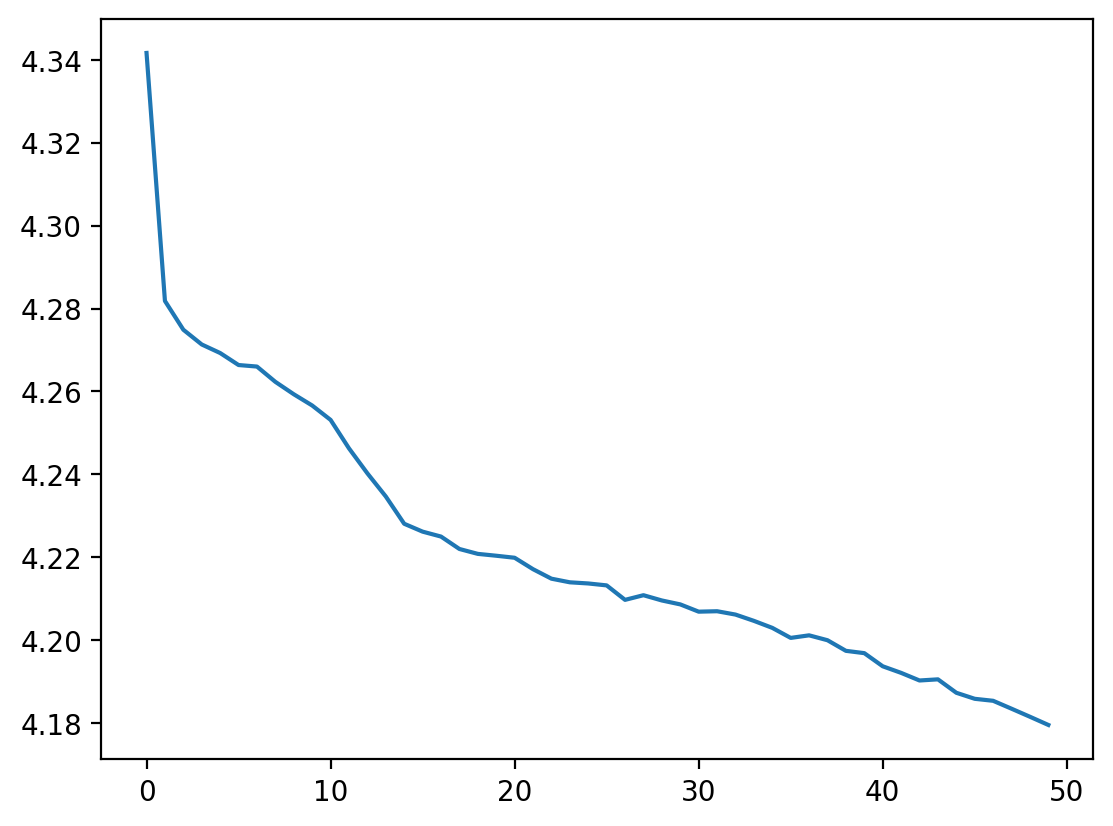

In [10]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [11]:
def generate(name):
    """ Velocity Prediction """

    # Get data to predict
    with open(PATH + name+'.pickle', 'rb') as filepath:
        notes = pickle.load(filepath)

    print('Initiating music generation process.......')

    # Creating data input
    n_patterns = len(notes)
    network_input = []
    for idx,_ in enumerate(notes) :
        network_input.append(_[:])
        network_input[-1][0] = (network_input[-1][0] - minv) / (maxv - minv)

    network_input = np.reshape(network_input, (n_patterns, 3,1))
    model = create_network(network_input)
    print('Loading Model weights.....')
    model.load_weights(PATH+modelname)
    print('Model Loaded')

    # Velocity Prediction
    prediction_output = generate_notes(model, network_input)
    create_midi(i,notes,prediction_output)

In [12]:

def generate_notes(model, network_input):
    """ Velocity Prediction with Pitch, Offset and Duration """
    prediction_output = []

    #  0-127 Velocity Prediction
    for note_index in range(network_input.shape[0]):
        prediction_input = np.reshape(network_input[note_index], (1, len(network_input[note_index]), 1))
        prediction = model.predict(prediction_input, verbose=0)
        prediction_output.append(int(np.where(prediction==np.max(prediction))[1]))

    return prediction_output

In [13]:
def create_midi(name,network_input,prediction_output):
    """ Put the predicted velocity value into the actual MIDI and save it. """
    offset = 0
    output_notes = []

    for idx,pattern in enumerate(network_input):
        new_note = note.Note(pattern[0])
        new_note.volume.velocity =  prediction_output[idx]
        new_note.offset = pattern[1]
        new_note.quarterLength=pattern[2]
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    midi_stream = stream.Stream(output_notes)

    print('Saving Output file as midi....')

    midi_stream.write('midi', fp='/content/drive/MyDrive/output/'+name+'.mid')

In [14]:
midi_names = ['80-46-1', '81-67-1', '81-67-2', '82-31-1', '83-18-1', '84-35-1', '84-35-2', '85-55-1', '86-30-1', '87-38-1', '88-36-1', '88-36-2', '89-35-1', '90-43-1']
for i in midi_names : 
  generate(i)

Initiating music generation process.......
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 128)            66560     
                                                                 
 dropout_2 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 3, 128)            131584    
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               98560     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (D